In [2]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from utils import tools
from modules.cae_base_module import CAEBaseModule
from models.reference_cae import ReferenceCAE
from datasets.lunar_analogue import LunarAnalogueDataModule

%matplotlib inline
plt.style.use('seaborn')

In [6]:
default_path = os.path.join(os.getcwd(), '../configs/reference_cae.yaml')
config = tools.config_from_command_line(default_path)

Experimental parameters
------
experiment-parameters: {'name': 'ReferenceCAE', 'log_dir': 'logs'}
data-parameters: {'root_data_path': '/home/brahste/Datasets/LunarAnalogue', 'glob_pattern_train': '**/nov-labelled/trainval/*.jpeg', 'glob_pattern_test': '**/nov-labelled/test/**/*.jpeg', 'train_fraction': 0.9, 'batch_size': 32}
module-parameters: {'learning_rate': 0.005, 'weight_decay_coefficient': 0.1} 



In [2]:
datamodule = LunarAnalogueDataModule(**config['data-parameters'])
datamodule.setup('test')

model = ReferenceCAE()

module = CAEBaseModule(model, **config['module-parameters'])

# Here, use the relative path to the checpoint you want to test with
checkpoint = torch.load('../logs/ReferenceCAE/version_0/checkpoints/val_loss=0.08-epoch=26.ckpt')
module.load_state_dict(checkpoint['state_dict'])

NameError: name 'LunarAnalogueDataModule' is not defined

In [1]:
# Run test step manually
test_novelty_scores = []
test_novelty_labels = []

module.model.eval()  # Freeze dropout and batch normalization parameters
with torch.no_grad():
    for batch_nb, batch in enumerate(datamodule.test_dataloader()):
        result = module.test_step(batch, batch_nb)
        print(f'[BATCH {batch_nb}] Testing...')
        test_novelty_scores.extend(result['scores'].cpu().numpy())
        test_novelty_labels.extend(result['labels'].cpu().numpy())

NameError: name 'module' is not defined

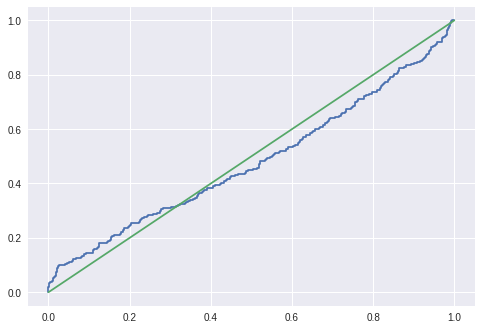

Model ROC AUC:  0.4809412869392673
Random ROC AUC:  0.5


In [10]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(test_novelty_labels, test_novelty_scores)
roc_auc_score = metrics.roc_auc_score(test_novelty_labels, test_novelty_scores)
roc_auc_score_rand = metrics.roc_auc_score([*[0.]*400, *[1.]*400], [0.5]*800)

plt.plot(fpr, tpr)
plt.plot([0., 1.], [0., 1.])
plt.show()
print('Model ROC AUC: ', roc_auc_score)
print('Random ROC AUC: ', roc_auc_score_rand)

# Discussion

Based on this preliminary experiment it appears that the ability for the CAE detector to classify novel samples is no better than random. This beahviour was observered, at rates worse than random, in the PCA detector too. A number of explanations for the CAE's low classification quality are plausible and will require further invesigation. Perhaps the most obvious reason is that for the reference CAE the dimensional reduction is low at only 1/16. For an input image of size $512\times 512 \times 3$ there are $786,432$ parameters that are encoded into $49,152$ parameters in the latent space. It is possible that for images of this size too much information is preserved in that latent space that reconsructions are trivially mapped from input to output. From the work done with the same model on the Martian dataset (Stefanuk, 2020), where it is known that ROC AUCs near 0.7 can be achieved, the reduction takes inputs from the $64\times 64\times 6 = 24576$ dimensional space and encodes them into a mere $768$ dimensions (this time a 32x reduction, since the inputs are 6-channel multispectral images). Following this vein, a more substantial reduction between the input and latent space could improve detection efficacy.

Another possible culprit for the CAE's poor detection performance could be the whole-image nature of the detection being carried out. When the model is fed entire images to classify as novel or typical, only small patches of these images contain novel content. In such cases the broader context and structure of the image may be diluting the novel content. As was conducted in our previous literature, cropping the images into small patches (e.g. $64\times64$ pixels) may help resolve this dilemma by capturing larger fractions of novel content within each novel image. This method of using small crops was used in the Martian dataset as well, no douby improving the overall performance of their detections (Kerner et. al., 2020).

Finally, the method of novelty detection employed in this script is one of simple thresholding. By assigning a global attribute to each image we are implicitly assuming that the error distribution between each input and reconstruction is irrelevant to the presence of a novelty. Given that we are operating on whole images, this assumption is grossly misplaced. If instead we were working on small patches within each image than the spatially-independent novelty assumption would have more merit, but would still misrepresent the nature of the problem. As was shown by Kerner et. al (2018), such patches can contain a variety of novel content that include both spectral and morphological components. As such it is worth examining how performance can be boosted by cascading a binary CNN with the CAE to infer whether the stucture of the error map itself is novel.

**Note: This model hasn't been equipped with dropout yet, this may improve generalization and (unfortunately) reduce the performance of the novelty detector further... changes with dropout coming soon**